In [5]:
import os
import glob
import random
from typing import Tuple

import pandas as pd
import numpy as np
import cv2
from tqdm.notebook import tqdm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.pyplot as plt
from IPython.display import HTML
from base64 import b64encode
import librosa
import librosa.display

In [2]:
def load_video(
    path_videos: str,
    file_name: str
) -> Tuple[np.ndarray, float]:
    """
    """
    video = cv2.VideoCapture(os.path.join(path_videos, file_name));
    fps = video.get(cv2.CAP_PROP_FPS)
    ret, frame = video.read()
    frames = []

    while ret:
    
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        ret, frame = video.read()
    
    frames = np.stack(frames)
    
    return frames, fps


def extract_save_frames(
    path_videos: str,
    file_name: str,
    path_save: str,
    size: tuple,
    extract_every: int = 1
) -> list:
    """
    """
    if not os.path.isdir(path_save):
        os.mkdir(path_save)
        
    video = cv2.VideoCapture(os.path.join(path_videos, file_name))
    fps = video.get(cv2.CAP_PROP_FPS)
    ret, frame = video.read()
    count = 1
    data = []
    
    while ret:
        
        if not (count -1) % extract_every:

            frame_name = f"{file_name.replace('.mp4', '')}_frame_{count}.jpg"
            data.append({
                'Filename': file_name,
                'FrameName': frame_name,
                'Fps': fps,
                'Count': count,
                'Size': f'{size[0]}x{size[1]}'
            })
            #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, size)
            cv2.imwrite(os.path.join(path_save, frame_name), frame)

        ret, frame = video.read()
        count += 1
        
    return data

In [17]:
path_data = os.path.join(os.getcwd(), 'MOSI')
path_videos = os.path.join(path_data, 'videos')

df = pd.read_csv(os.path.join(path_data, 'labels.csv'))

video_files = os.listdir(path_videos)

In [18]:
df.head()

Filename      Start        End  Score Sentiment   Type
0  03bSnISJMiM_1  51.904533  55.945351   2.40  positive  train
1  03bSnISJMiM_2  56.045124  66.780724  -0.80  negative  train
2  03bSnISJMiM_3  66.780724  68.736282  -1.00  negative  train
3  03bSnISJMiM_4  68.736282  70.542175  -1.75  negative  train
4  03bSnISJMiM_5  70.542175  71.699547   0.00  positive  train

<AxesSubplot:>

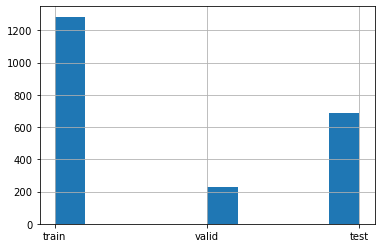

In [19]:
df['Type'].hist()

In [20]:
df.isnull().sum()

Filename     0
Start        0
End          0
Score        0
Sentiment    0
Type         0
dtype: int64

In [24]:
size = (224, 224)
extract_every = 5

path_save_frames = os.path.join(os.getcwd(), f'frames{size[0]}x{size[1]}')

data_frames = []

for i, vf in enumerate(tqdm(video_files)):
    
    data = extract_save_frames(path_videos, vf, path_save_frames, size, extract_every)
    data_frames.extend(data)
    
df_frames = pd.DataFrame(data_frames)
df_frames.to_csv('df_frames.csv', index=False)

  0%|          | 0/2199 [00:00<?, ?it/s]

In [25]:
df_frames.head()

Filename                   FrameName   Fps  Count     Size
0  03bSnISJMiM_1.mp4   03bSnISJMiM_1_frame_1.jpg  30.0      1  224x224
1  03bSnISJMiM_1.mp4   03bSnISJMiM_1_frame_6.jpg  30.0      6  224x224
2  03bSnISJMiM_1.mp4  03bSnISJMiM_1_frame_11.jpg  30.0     11  224x224
3  03bSnISJMiM_1.mp4  03bSnISJMiM_1_frame_16.jpg  30.0     16  224x224
4  03bSnISJMiM_1.mp4  03bSnISJMiM_1_frame_21.jpg  30.0     21  224x224

In [140]:
!mkdir frames_128x128

In [141]:
path_save_frames = os.path.join(os.getcwd(), 'frames_128x128')

data_frames = []

for vf in tqdm(video_files):
    data = extract_save_frames(path_videos, vf, path_save_frames, (128, 128))
    data_frames.extend(data)
    
df_frames = pd.DataFrame(data_frames)
df_frames.to_csv('df_frames.csv', index=False)

  0%|          | 0/2199 [00:00<?, ?it/s]

In [120]:
df_frames = pd.read_csv('df_frames.csv')

df['Filename'] = df['Filename'].apply(lambda x: f'{x}.mp4')

df_frames = pd.read_csv('df_frames.csv') 
df_frames = pd.merge(
    df_frames,
    df,
    how='left',
    on='Filename'
)

In [122]:
df_frames.head()

Filename                      FrameName   Fps  Count      Start  \
0  03bSnISJMiM_1.mp4  03bSnISJMiM_1.mp4_frame_1.jpg  30.0      1  51.904533   
1  03bSnISJMiM_1.mp4  03bSnISJMiM_1.mp4_frame_2.jpg  30.0      2  51.904533   
2  03bSnISJMiM_1.mp4  03bSnISJMiM_1.mp4_frame_3.jpg  30.0      3  51.904533   
3  03bSnISJMiM_1.mp4  03bSnISJMiM_1.mp4_frame_4.jpg  30.0      4  51.904533   
4  03bSnISJMiM_1.mp4  03bSnISJMiM_1.mp4_frame_5.jpg  30.0      5  51.904533   

         End  Score Sentiment   Type  
0  55.945351    2.4  positive  train  
1  55.945351    2.4  positive  train  
2  55.945351    2.4  positive  train  
3  55.945351    2.4  positive  train  
4  55.945351    2.4  positive  train

In [123]:
len(df_frames)

282728

In [124]:
df_frames['Fps'].unique()

array([30.])

In [125]:
df_frames.groupby('Filename')['Count'].max().sort_values(ascending=False)

Filename
2WGyTLYerpo_44.mp4    1575
VCslbP0mgZI_8.mp4     1159
ob23OKe5a9Q_9.mp4      960
f_pcplsH_V0_12.mp4     932
phBUpBr1hSo_8.mp4      847
                      ... 
I5y0__X72p0_15.mp4      17
v0zCBqDeKcE_16.mp4      16
BvYR0L6f2Ig_18.mp4      14
BI97DNYfe5I_20.mp4      12
9qR7uwkblbs_33.mp4       7
Name: Count, Length: 2199, dtype: int64

In [126]:
print(
    "Average number of frames is: "
    f"{np.mean(df_frames.groupby('Filename')['Count'].max().values)}"
)

Average number of frames is: 128.57116871305138


In [116]:
frame_counts = df_frames.groupby('Filename')['Count'].max().sort_values(ascending=False).to_dict()

file_name = max(frame_counts, key=frame_counts.get)

mp4 = open(os.path.join(path_videos, file_name),'rb').read()

data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [132]:
df_frames.loc[(df_frames['Filename'] == file_name)].iloc[0]

Filename                 2WGyTLYerpo_44.mp4
FrameName    2WGyTLYerpo_44.mp4_frame_1.jpg
Fps                                    30.0
Count                                     1
Start                            127.213379
End                              127.213379
Score                                   0.2
Sentiment                          positive
Type                                  train
Name: 17844, dtype: object

In [133]:
max(df_frames.loc[(df_frames['Filename'] == file_name), 'Count'])

1575

In [134]:
file_name = list(frame_counts.keys())[1]

mp4 = open(os.path.join(path_videos, file_name),'rb').read()

data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [135]:
df_frames.loc[(df_frames['Filename'] == file_name)]

Filename                         FrameName   Fps  Count  \
243990  VCslbP0mgZI_8.mp4     VCslbP0mgZI_8.mp4_frame_1.jpg  30.0      1   
243991  VCslbP0mgZI_8.mp4     VCslbP0mgZI_8.mp4_frame_2.jpg  30.0      2   
243992  VCslbP0mgZI_8.mp4     VCslbP0mgZI_8.mp4_frame_3.jpg  30.0      3   
243993  VCslbP0mgZI_8.mp4     VCslbP0mgZI_8.mp4_frame_4.jpg  30.0      4   
243994  VCslbP0mgZI_8.mp4     VCslbP0mgZI_8.mp4_frame_5.jpg  30.0      5   
...                   ...                               ...   ...    ...   
245144  VCslbP0mgZI_8.mp4  VCslbP0mgZI_8.mp4_frame_1155.jpg  30.0   1155   
245145  VCslbP0mgZI_8.mp4  VCslbP0mgZI_8.mp4_frame_1156.jpg  30.0   1156   
245146  VCslbP0mgZI_8.mp4  VCslbP0mgZI_8.mp4_frame_1157.jpg  30.0   1157   
245147  VCslbP0mgZI_8.mp4  VCslbP0mgZI_8.mp4_frame_1158.jpg  30.0   1158   
245148  VCslbP0mgZI_8.mp4  VCslbP0mgZI_8.mp4_frame_1159.jpg  30.0   1159   

            Start         End  Score Sentiment   Type  
243990  64.356239  103.108162   -1.6  negative  train  
243991  64.356239  103.108162   -1.6  negative  train  
243992  64.356239  103.108162   -1.6  negative  train  
243993  64.356239  103.108162   -1.6  negative  train  
243994  64.356239  103.108162   -1.6  negative  train  
...           ...         ...    ...       ...    ...  
245144  64.356239  103.108162   -1.6  negative  train  
245145  64.356239  103.108162   -1.6  negative  train  
245146  64.356239  103.108162   -1.6  negative  train  
245147  64.356239  103.108162   -1.6  negative  train  
245148  64.356239  103.108162   -1.6  negative  train  

[1159 rows x 9 columns]

In [166]:
dir_name = 'extracted_faces'
path_faces = os.path.join(os.getcwd(), dir_name)

if not os.path.isdir(path_faces):
    os.mkdir(path_faces)

path_model = os.path.join(os.getcwd(), 'saved_models', 'cv_model')
path_frames = os.path.join(os.getcwd(), 'frames224x224')

prototxt_path = os.path.join(path_model, 'deploy.prototxt')
caffemodel_path = os.path.join(path_model, 'weights.caffemodel')

model = cv2.dnn.readNetFromCaffe(prototxt_path, caffemodel_path)

In [201]:
images = os.listdir(path_frames)
images = list(filter(lambda x: '.jpg' in x, images))

required_conf = 0.7

face_width_mean = 62

face_widths = []

for iii, img in enumerate(tqdm(images)):
    
    path_save_image = os.path.join(path_faces, img.replace('frame', 'face'))
    
    image = cv2.imread(os.path.join(path_frames, img))
    
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

    model.setInput(blob)
    detections = model.forward()
    
    detections = detections.squeeze(axis=(0, 1))
    
    idx_max_conf = np.argmax(detections[:, 2])

    confidence = detections[idx_max_conf, 2]

    if confidence > required_conf:
        
        box = detections[idx_max_conf, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        
        if startY < 0:
            startY = 0
        
        frame = image[startY: endY, startX: endX]
        
        face_widths.append(frame.shape[1])
        
        '''
        if frame.shape[1] < face_width_mean:
            
            print(f'Probable false detection for image: {img}. Skipping saving...')
            continue'''
        
        if frame.size > 0:
            cv2.imwrite(path_save_image, frame)
            
        else:
            print(
                f"Frame size is 0! Image: {img} "
                f"startX {startX} endX {endX} startY {startY} endY {endY}"
            )
            break
    else:
        print(f"Could not find face on image: {img}")


print(f'Mean width is: {np.mean(face_widths):.3f}')

  0%|          | 0/57400 [00:00<?, ?it/s]

Could not find face on image: 03bSnISJMiM_6_frame_1.jpg
Could not find face on image: 03bSnISJMiM_6_frame_11.jpg
Could not find face on image: 03bSnISJMiM_6_frame_51.jpg
Could not find face on image: 03bSnISJMiM_6_frame_6.jpg
Could not find face on image: 0h-zjBukYpk_25_frame_11.jpg
Could not find face on image: 0h-zjBukYpk_25_frame_186.jpg
Could not find face on image: 0h-zjBukYpk_25_frame_191.jpg
Could not find face on image: 0h-zjBukYpk_25_frame_221.jpg
Could not find face on image: 0h-zjBukYpk_25_frame_226.jpg
Could not find face on image: 0h-zjBukYpk_25_frame_241.jpg
Could not find face on image: 0h-zjBukYpk_25_frame_271.jpg
Could not find face on image: 0h-zjBukYpk_25_frame_281.jpg
Could not find face on image: 0h-zjBukYpk_25_frame_46.jpg
Could not find face on image: 0h-zjBukYpk_25_frame_6.jpg
Could not find face on image: 0h-zjBukYpk_5_frame_141.jpg
Could not find face on image: 0h-zjBukYpk_5_frame_146.jpg
Could not find face on image: 2iD-tVS8NPw_1_frame_1.jpg
Could not find f

Could not find face on image: cM3Yna7AavY_5_frame_41.jpg
Could not find face on image: cM3Yna7AavY_5_frame_46.jpg
Could not find face on image: cXypl4FnoZo_22_frame_16.jpg
Could not find face on image: d3_k5Xpfmik_14_frame_136.jpg
Could not find face on image: d6hH302o4v8_33_frame_16.jpg
Could not find face on image: d6hH302o4v8_33_frame_21.jpg
Could not find face on image: f_pcplsH_V0_10_frame_76.jpg
Could not find face on image: f_pcplsH_V0_10_frame_81.jpg
Could not find face on image: f_pcplsH_V0_10_frame_86.jpg
Could not find face on image: f_pcplsH_V0_11_frame_36.jpg
Could not find face on image: f_pcplsH_V0_11_frame_6.jpg
Could not find face on image: f_pcplsH_V0_12_frame_636.jpg
Could not find face on image: f_pcplsH_V0_12_frame_641.jpg
Could not find face on image: f_pcplsH_V0_13_frame_11.jpg
Could not find face on image: f_pcplsH_V0_13_frame_16.jpg
Could not find face on image: f_pcplsH_V0_13_frame_6.jpg
Could not find face on image: f_pcplsH_V0_1_frame_46.jpg
Could not find f

Could not find face on image: ob23OKe5a9Q_14_frame_216.jpg
Could not find face on image: ob23OKe5a9Q_14_frame_221.jpg
Could not find face on image: ob23OKe5a9Q_14_frame_226.jpg
Could not find face on image: ob23OKe5a9Q_14_frame_231.jpg
Could not find face on image: ob23OKe5a9Q_14_frame_236.jpg
Could not find face on image: ob23OKe5a9Q_14_frame_241.jpg
Could not find face on image: ob23OKe5a9Q_14_frame_246.jpg
Could not find face on image: ob23OKe5a9Q_14_frame_251.jpg
Could not find face on image: ob23OKe5a9Q_14_frame_256.jpg
Could not find face on image: ob23OKe5a9Q_14_frame_26.jpg
Could not find face on image: ob23OKe5a9Q_14_frame_261.jpg
Could not find face on image: ob23OKe5a9Q_14_frame_266.jpg
Could not find face on image: ob23OKe5a9Q_14_frame_31.jpg
Could not find face on image: ob23OKe5a9Q_14_frame_36.jpg
Could not find face on image: ob23OKe5a9Q_14_frame_41.jpg
Could not find face on image: ob23OKe5a9Q_14_frame_81.jpg
Could not find face on image: ob23OKe5a9Q_14_frame_91.jpg
Cou

## Generate spectograms

In [232]:
%matplotlib agg

path_spectograms = os.path.join(os.getcwd(), 'spectograms')

if not os.path.isdir(path_spectograms):
    os.mkdir(path_spectograms)


n_mels = 128
fmax = 8000

fig = plt.figure()

for i, vf in enumerate(tqdm(video_files)):
    
    path_save_spect = os.path.join(path_spectograms, f"{vf.split('.mp4')[0]}_spect.jpg")
    
    signal, sr = librosa.load(os.path.join(path_videos, vf))
    melspec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels, fmax=fmax)
    melspec_db = librosa.power_to_db(melspec, ref=np.max)
    
    img = librosa.display.specshow(melspec_db)
    fig.savefig(path_save_spect, ax=ax)
    fig.clear()

  0%|          | 0/2199 [00:00<?, ?it/s]

C:\Users\hkris\AppData\Local\Temp/ipykernel_17896/418138152.py:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ax" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig(path_save_spect, ax=ax)


In [284]:
df = pd.read_csv(os.path.join(path_data, 'labels.csv'))

df_text = pd.read_csv('df_text.csv')

df_frames = pd.read_csv('df_frames.csv')
df_frames['Filename'] = df_frames['Filename'].apply(lambda x: x.replace('.mp4', ''))

spectograms = os.listdir(path_spectograms)
images_faces = os.listdir(path_faces)

df_spect = pd.DataFrame({'Spectogram': spectograms})
df_spect['Filename'] = df_spect['Spectogram'].apply(lambda x: x.split('_spect')[0])

df_faces = pd.DataFrame({'Face': images_faces})
df_faces['FrameName'] = df_faces['Face'].apply(lambda x: x.replace('face', 'frame'))

df_frames = pd.merge(df_frames, df_faces, how='left', on='FrameName')

df_frames = pd.merge(df_frames, df_spect, how='left', on='Filename')
df_frames = pd.merge(df_frames, df, how='left', on='Filename')
df_frames = pd.merge(df_frames, df_text, how='left', on='Filename')

In [286]:
df_frames.head()

Filename                   FrameName   Fps  Count     Size  \
0  03bSnISJMiM_1   03bSnISJMiM_1_frame_1.jpg  30.0      1  224x224   
1  03bSnISJMiM_1   03bSnISJMiM_1_frame_6.jpg  30.0      6  224x224   
2  03bSnISJMiM_1  03bSnISJMiM_1_frame_11.jpg  30.0     11  224x224   
3  03bSnISJMiM_1  03bSnISJMiM_1_frame_16.jpg  30.0     16  224x224   
4  03bSnISJMiM_1  03bSnISJMiM_1_frame_21.jpg  30.0     21  224x224   

                        Face               Spectogram      Start        End  \
0   03bSnISJMiM_1_face_1.jpg  03bSnISJMiM_1_spect.jpg  51.904533  55.945351   
1   03bSnISJMiM_1_face_6.jpg  03bSnISJMiM_1_spect.jpg  51.904533  55.945351   
2  03bSnISJMiM_1_face_11.jpg  03bSnISJMiM_1_spect.jpg  51.904533  55.945351   
3  03bSnISJMiM_1_face_16.jpg  03bSnISJMiM_1_spect.jpg  51.904533  55.945351   
4  03bSnISJMiM_1_face_21.jpg  03bSnISJMiM_1_spect.jpg  51.904533  55.945351   

   Score Sentiment   Type                       Text  Nwords  
0    2.4  positive  train  anyhow it was really good       5  
1    2.4  positive  train  anyhow it was really good       5  
2    2.4  positive  train  anyhow it was really good       5  
3    2.4  positive  train  anyhow it was really good       5  
4    2.4  positive  train  anyhow it was really good       5

In [287]:
df_frames.isnull().sum()

Filename        0
FrameName       0
Fps             0
Count           0
Size            0
Face          369
Spectogram      0
Start           0
End             0
Score           0
Sentiment       0
Type            0
Text            8
Nwords          0
dtype: int64

In [288]:
df_frames.to_csv('data_multimodal.csv', index=False)

In [18]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def draw_images(images: np.ndarray ) -> None:
    """
    """
    plt.figure(figsize=(10,10))
    gs1 = gridspec.GridSpec(4, 5)
    gs1.update(wspace=0.025, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs1[i])
        ax.imshow(img, cmap='gray')
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')

    plt.subplots_adjust(top=0.94)
    plt.show()

In [19]:
df = pd.read_csv('data_multimodal.csv')

In [20]:
path_faces = os.path.join(os.getcwd(), 'extracted_faces')

df_faces = df.loc[(df['Face'].notnull())].reset_index(drop=True).copy()

df_faces['Face'] = df_faces['Face'].apply(lambda x: os.path.join(path_faces, x))

images = [Image.open(x) for x in random.choices(df_faces['Face'].tolist(), k=20)]

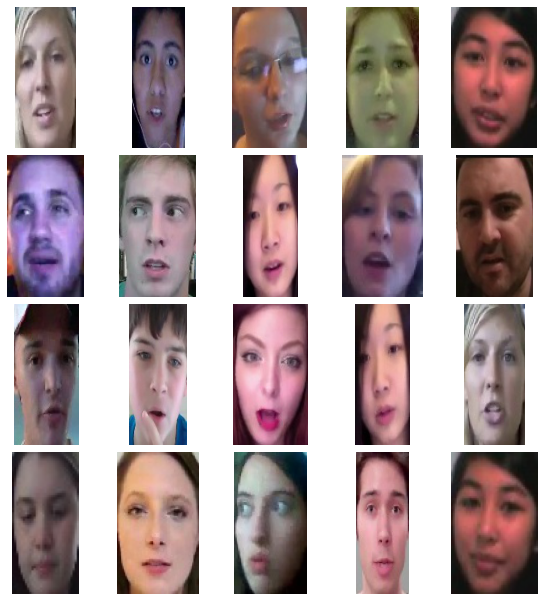

In [21]:
draw_images(images)

In [23]:
path_spectograms = os.path.join(os.getcwd(), 'spectograms')

df_spect = df.loc[:, ['Sentiment', 'Score', 'Type', 'Spectogram']].drop_duplicates().reset_index(drop=True).copy()
df_spect['PathSpectogram'] = df_spect['Spectogram'].apply(lambda x: os.path.join(path_spectograms, x))

images = [Image.open(x) for x in random.choices(df_spect['PathSpectogram'].tolist(), k=20)]

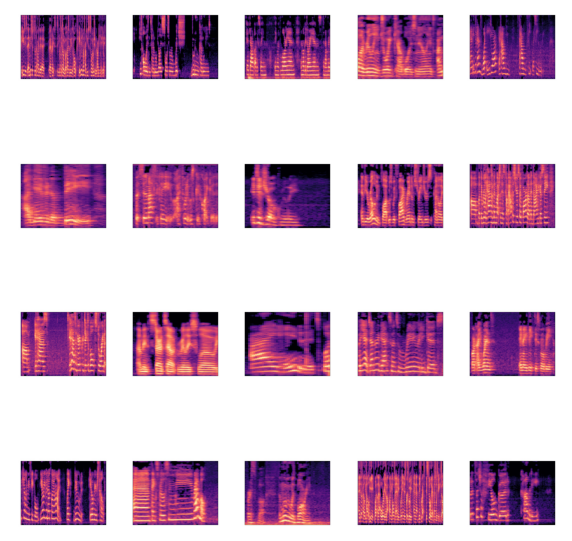

In [24]:
draw_images(images)